# Basic Concepts: Nodes, Edges & State

In [9]:
from typing import TypedDict
from langgraph.graph import END, StateGraph

class InputState(TypedDict):
    string_value: str
    numeric_value: int

# in LangGraph sempre modifichiamo lo stato e poi restituiamo il nuovo stato
def modify_state(input: InputState):
    print(f"Current value: {input}")
    return input # importante poichè definisce lo stato nel prossimo nodo (in questo caso invariato)


# creiamo il nostro grafo quindi passiamo lo state object, InputState, al costruttore StateGraph
# in questo modo definiamo il nostro grafo
graph = StateGraph(InputState)

# l'oggetto garfo ha molteplici metodi tra cui .add_node con il quale aggiungiamo un nodo al grafo

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

# dopo aver definito i nodi e gli archi, LangGraph deve sapere dove effetivamente iniziare,
# questo deve essere fatto creando un entrypoint 
# mettiamo come entrypoint del nostrografo il nodo branch_a
graph.set_entry_point("branch_a")

# prima di runnare il nostro grafo dobbiamo prima compilarlo 
# il metodo .compile valida il grafo controllando incosistenze logiche come: connessioni dimenticate o nodi non raggiungibili,
# e lo prepara per l'esecuzione come un runnable workflow 
runnable = graph.compile()

# un'altra cosa utile è visualizzare il grafo


# Visualize graph

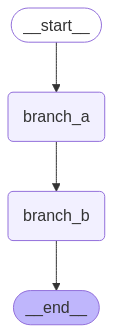

In [10]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        runnable.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Eseguiamo il nostro grafo con un input

per eseguire il grafo dobbiamo fornire uno stato di ingresso 

lo stato del grafo ha due argomenti string_value e numeric_value

se forniamo solo uno di essi, ad esempio, string_value comunque non va in errore grazie alla flessibilità di TypedDict.

Se avessimo usato pydantic per lo stato allora sarebbe stato necessario fornire entrambi nel modo corretto.

In [11]:

runnable.invoke({"string_value": "a"})

Current value: {'string_value': 'a'}
Current value: {'string_value': 'a'}


{'string_value': 'a'}

In [12]:
runnable.invoke({"string_value": "b", "numeric_value": 1})

Current value: {'string_value': 'b', 'numeric_value': 1}
Current value: {'string_value': 'b', 'numeric_value': 1}


{'string_value': 'b', 'numeric_value': 1}

ora proviamo ad esguire il grafo ma con un'altra funzione che modifica effettivamente lo stato del grafo 

In [13]:
def modify_state(input: InputState):
    input['string_value'] += "a"
    input['numeric_value'] += 1
    return input

graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)

graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()



Ora poichè il passaggio da un nodo all'altro cambia entrabi gli argomenti dello stato in questo caso è obbligatorio fornire entrambe gli argomenti che definiscono lo stato  

In [14]:
# vediamo che va in errore se non forniamo entrambi gli argomenti dello stato
# dobbiamo dare come stato iniziale del grafo entrambi gli argomenti
# ifatti va in erroe dicendo che manca numeric_value poiché nella funzione all'interno dei nodi
# va a prendere come chiave dello stato input['numeric_value'] per modificarlo
# ma se non lo trova da errore
try:
    runnable.invoke({"string_value": "a"})
except KeyError as e:
    print(e)

'numeric_value'


In [15]:
runnable.invoke({"string_value": "a", "numeric_value": 2})

{'string_value': 'aaa', 'numeric_value': 4}

### Perché non usare solo LCEL con la pipeline che modifica l'oggetto?

Proviamolo

### Spiegazione dei Runnable in LangChain

I **`Runnable`** in LangChain sono componenti modulari che permettono di eseguire funzioni e modelli in modo strutturato, rendendo più semplice la creazione di **pipeline** e **workflow AI**.

### **Cosa fanno i `Runnable`?**
- **Standardizzano l'esecuzione**: qualsiasi funzione, modello o operazione diventa un oggetto eseguibile con metodi chiari.
- **Gestiscono il flusso dei dati**: possono essere concatenati, composti e orchestrati.
- **Supportano funzionalità avanzate**: come batch processing, streaming e logging.

---

## **Tipologie di Runnable e loro utilizzo**

### 1️⃣ **RunnableLambda**
📌 **Esegue una funzione Python generica**.

```python
from langchain_core.runnables import RunnableLambda

def double(x):
    return x * 2

runnable = RunnableLambda(double)
print(runnable.invoke(10))  # Output: 20
```

✔️ Utile per trasformazioni semplici.

---

### 2️⃣ **RunnablePassthrough**
📌 **Passa il valore in input direttamente come output** (utile per debugging o connessioni tra moduli).

```python
from langchain_core.runnables import RunnablePassthrough

runnable = RunnablePassthrough()
print(runnable.invoke("Hello"))  # Output: "Hello"
```

✔️ Utile per mantenere il flusso senza alterarlo.

---

### 3️⃣ **RunnableSequence**
📌 **Concatena più Runnable in sequenza**.

```python
from langchain_core.runnables import RunnableLambda, RunnableSequence

def double(x):
    return x * 2

def add_five(x):
    return x + 5

pipeline = RunnableSequence(RunnableLambda(double), RunnableLambda(add_five))

print(pipeline.invoke(10))  # Output: 25 (10*2 + 5)
```

✔️ Utile per costruire pipeline più complesse.

---

### 4️⃣ **RunnableParallel**
📌 **Esegue più Runnable in parallelo e restituisce un dizionario dei risultati**.

```python
from langchain_core.runnables import RunnableParallel

runnable = RunnableParallel(
    square=RunnableLambda(lambda x: x**2),
    cube=RunnableLambda(lambda x: x**3)
)

print(runnable.invoke(3))
# Output: {'square': 9, 'cube': 27}
```

✔️ Utile per calcolare più risultati in parallelo.

---

### 5️⃣ **RunnableBranch**
📌 **Esegue una funzione diversa a seconda dell'input**.

```python
from langchain_core.runnables import RunnableBranch

runnable = RunnableBranch(
    (lambda x: x < 10, RunnableLambda(lambda x: f"Small: {x}")),
    (lambda x: x >= 10, RunnableLambda(lambda x: f"Big: {x}"))
)

print(runnable.invoke(5))   # Output: "Small: 5"
print(runnable.invoke(20))  # Output: "Big: 20"
```

✔️ Utile per routing condizionale.

---

## **🔥 Perché usare i `Runnable`?**
- ✅ **Struttura modulare**: ogni pezzo del flusso è separato e riutilizzabile.
- ✅ **Facile da comporre**: puoi concatenare, parallelizzare e condizionare.
- ✅ **Supporto per batch e streaming**: `batch()` per più input e `stream()` per output incrementali.

In [16]:
from langchain_core.runnables import RunnableLambda

runnable = RunnableLambda(modify_state) # esegue la funzione al suo interno

chain = runnable | runnable

chain.invoke({"string_value": "a", "numeric_value": 3})

{'string_value': 'aaa', 'numeric_value': 5}

in questo caso vediamo che è più semplice da implementare con LCEL invece di definre un grafo per eseguire una funzione più volte in sequenza.

Tuttavia quando i workflows diventano più intrecciati e non sequenziali (uno dopo l'altro) diventa complicato continuare ad usare LCEL.

È consigliabile utilizzare il meglio di entrambi i mondi (Grafi e LCEL) per semplici workflows usare LCEL ed usare LCEL all'interno dei LangGraph workflows.

## Cycles and Conditional Edges

In [21]:
# funzione che cambia lo stato del grafo
def modify_state(input: InputState):
    input['string_value'] += "a"
    input['numeric_value'] += 1
    return input

# funzione che stabilisce verso quale nodo andare (non modifica lo stato)
# viene usata per i conditional_edges e per usarli dobbiamo leggere lo stato del grafo
# senza andare a modificarlo
def router(input: InputState):
    if input['numeric_value'] < 5:
        return "branch_a"
    else:
        return "__end__"
    
graph = StateGraph(InputState)

# dentro i nodi mettiamo le funzioni che modificano lo stato del grafo
graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)


graph.add_edge("branch_a", "branch_b")

# arco condizionale che usa la nostra funzione route
graph.add_conditional_edges(
    "branch_b", router, path_map={"branch_a": "branch_a", "__end__": END}
)


graph.set_entry_point("branch_a")


runnable = graph.compile()

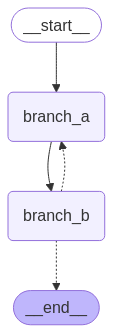

In [22]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        runnable.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [23]:
runnable.invoke({"string_value": "a", "numeric_value": 1})

{'string_value': 'aaaaa', 'numeric_value': 5}

### Reducer Functions

I **reducers** sono essenziali per determinare come gli aggiornamenti dai nodi vengono applicati allo stato.

Ogni chiave nello stato ha la sua propria indipendente reducer function.

Se nessuna reducer function è specificata, allora l'aggiornamento alla specifica chiave sarà la sovrascrizione di default sul valore esistente.

Nell'esempio che abbiamo visto con la funzione modify_state lo abbiamo fatto un po diverso, senza usare una Reduce function.

```python
def modify_state(input: InputState):
    input['string_value'] += "a"
    input['numeric_value'] += 1
    return input
```

Nel seguente condice vediamo una funzione Reduce che aggiorna lo stato senza usare l'operatore +=


Nel segunete esempio la Reduce function è **add** from operator.
Questa funzione solamente aggiunge all'input type

- Esempio pratico di add:

```python
from operator import add

print(add(2, 3))       # 2 + 3 = 5
print(add("Hello, ", "World!"))  # Concatenazione stringhe: "Hello, World!"
print(add([1, 2], [3, 4]))  # Unione liste: [1, 2, 3, 4]
```


### Annotaded

```python
from typing import Annotated

Annotated[tipo, metadato]
```

Dove:

- tipo → è il tipo di dato standard (es. int, str, list).
- metadato → è un valore aggiuntivo (può essere una funzione, un oggetto o qualsiasi informazione extra).

Nel tuo codice:

```python

list_value: Annotated[list[str], add]
```
significa che i nuovi elementi vengono aggiunti alla lista esistente invece di sostituirla. Dice come trattare il dato.

Annotated è uno strumento potente per definire non solo il tipo di una variabile, ma anche come dovrebbe essere trattata in un sistema.


### esempio


#### **📌 Esempio con `StateGraph`**
```python
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, END
from operator import add

class InputState(TypedDict):
    no_change_value: str
    string_value: Annotated[str, add]  # Concatena stringhe
    numeric_value: Annotated[int, add]  # Somma numeri
    list_value: Annotated[list[str], add]  # Unisce liste

def update_state(state: InputState) -> InputState:
    return {
        "no_change_value": state["no_change_value"],
        "string_value": "LangChain ",
        "numeric_value": 10,
        "list_value": ["AI", "Graph"]
    }

# Creiamo un grafo con un solo nodo che aggiorna lo stato
workflow = StateGraph(InputState)
workflow.add_node("update", update_state)
workflow.set_entry_point("update")
workflow.add_edge("update", END)

# Eseguiamo il workflow con uno stato iniziale
app = workflow.compile()
initial_state = {
    "no_change_value": "Fixed",
    "string_value": "Hello",
    "numeric_value": 5,
    "list_value": ["LangChain"]
}

output = app.invoke(initial_state)
print(output)
```

---

### **🔹 Risultato atteso**
Dopo l'aggiornamento dello stato, otteniamo:
```python
{
    "no_change_value": "Fixed",   # Non cambia
    "string_value": "HelloLangChain ",  # Concatenazione
    "numeric_value": 15,  # 5 + 10 = 15
    "list_value": ["LangChain", "AI", "Graph"]  # Unione liste
}
```

In [37]:
from typing import TypedDict, Annotated
from langgraph.graph import END, StateGraph
from operator import add

class InputState(TypedDict):
    no_change_value: str
    string_value: Annotated[str, add] # concatena stringhe
    numeric_value: Annotated[int, add] # somma numeri
    list_value: Annotated[list[str], add] # unisce liste 


# definiamo la funzione che modifica lo stato 
def modify_state(input: InputState):
    print(f"Current state: {input}")
    return input 


In [38]:
# costruiamo il grafo 

graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)

graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END) # lo stato output di branch_b entra nel nodo END 

graph.set_entry_point("branch_a")

runnable = graph.compile()

In [39]:
runnable.invoke({"no_change_value": "a", "string_value": "a", "numeric_value": 1, "list_value": ["a"]})

Current state: {'no_change_value': 'a', 'string_value': 'a', 'numeric_value': 1, 'list_value': ['a']}
Current state: {'no_change_value': 'a', 'string_value': 'aa', 'numeric_value': 2, 'list_value': ['a', 'a']}


{'no_change_value': 'a',
 'string_value': 'aaaa',
 'numeric_value': 4,
 'list_value': ['a', 'a', 'a', 'a']}

## Alternative State

Abbiamo utilizzato TypedDict per definire il nostrao stato.

Ma possiamo usare anche **Pydantic** il quale porta automaticamnete il type validation.

Quindi proviamo a definire lo stato con **pydantic**

In [ ]:
from langgraph.graph import END, StateGraph

from pydantic import BaseModel

class InputState(BaseModel):
    string_value: str
    numeric_value: int 

def modify_state(input: InputState):
    string_value = input.string_value
    print(string_value)
    return input

graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)

graph.add_edge("branch_a", "branch_b")

graph.add_edge("branch_b", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()



In [42]:
runnable.invoke({"string_value": "a", "numeric_value": "a"}) # da validatio error perche "a" è una stringa non un int

ValidationError: 1 validation error for InputState
numeric_value
  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='a', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/int_parsing